In [2]:
import os.path as op
from src.datasets.human_mesh_tsv import MeshTSVYamlDataset

yaml_file = "/home/juno/datasets/Tax-H36m-coco40k-Muco-UP-Mpii/train.yaml"
# yaml_file = "/home/juno/datasets/3dpw/test_has_gender.yaml"
is_train = True
scale_factor = 1
train_dataloader = MeshTSVYamlDataset(yaml_file, is_train, False, scale_factor)

/home/juno/anaconda3/envs/hgcn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import cv2
def draw_vetices(background, vertices_2d, color, r = 1, bone=None, text=False):
    image = background.copy() 
    vertices_norm = ((vertices_2d + 1) * 0.5) * image.shape[1]
    for jj in range(vertices_2d.shape[0]):
        x = int(vertices_norm[jj,0])
        y = int(vertices_norm[jj,1])
        cv2.circle(image,(x,y), r, color, -1) 
        if text==True:
            cv2.putText(image , str(jj), (x+5,y+5), cv2.FONT_HERSHEY_PLAIN,  1, color, 1, cv2.LINE_AA)
    if bone != None:
        for (i, j) in bone:
            xi = int(vertices_norm[i,0])
            yi = int(vertices_norm[i,1])
            xj = int(vertices_norm[j,0])
            yj = int(vertices_norm[j,1])
            cv2.line(image, (xi,yi), (xj,yj), (255,255,255))
    
    return image

In [25]:
(img_keys, images, annotations) = train_dataloader[14]

In [26]:
mjm_mask = annotations['mjm_mask']
mvm_mask = annotations['mvm_mask']

In [27]:
mvm_mask.shape

torch.Size([431, 1])

In [28]:
num_zeros = (mvm_mask==0).sum().item()
print(num_zeros)

18


In [761]:
from src.modeling._smpl import SMPL, Mesh
import torch
smpl = SMPL().to(torch.device('cuda'))
mesh_sampler = Mesh()
device = torch.device('cuda')

In [762]:
import src.modeling.data.config as cfg
gt_2d_joints = annotations['joints_2d'].cuda(device)
gt_2d_joints = gt_2d_joints[cfg.J24_TO_J14, :]

In [763]:
test = gt_2d_joints.unsqueeze(0)
test.shape

torch.Size([1, 14, 3])

In [764]:
gt_3d_joints = annotations['joints_3d'].cuda(device)
gt_3d_pelvis = gt_3d_joints[cfg.J24_NAME.index('Pelvis'), :3]
gt_3d_joints = gt_3d_joints[cfg.J24_TO_J14, :]
gt_3d_joints[:, :3] = gt_3d_joints[:, :3] - gt_3d_pelvis[None, :]

In [765]:
gt_pose = annotations['pose'].cuda()
gt_betas = annotations['betas'].cuda()
gt_vertices = smpl(gt_pose.unsqueeze(0), gt_betas.unsqueeze(0))

In [766]:
gt_vertices.shape

torch.Size([1, 6890, 3])

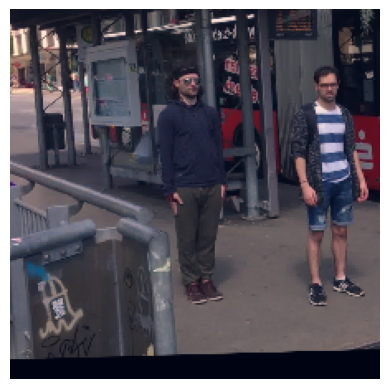

In [767]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 將 PyTorch 張量轉換為 NumPy 陣列
img_np = images.numpy()
min_val = img_np.min()
max_val = img_np.max()
img_np = (img_np - min_val) / (max_val - min_val)

# 轉換顏色通道從 (3, 224, 224) 到 (224, 224, 3)
img_np = np.transpose(img_np, (1, 2, 0))
img_np_bgr = img_np[:, :, ::]
# 顯示圖片
plt.imshow(img_np_bgr)
plt.axis('off')  # 隱藏坐標軸
plt.show()

In [768]:
pred_camera = torch.tensor([[1, 0, 0]])
from src.utils.geometric_layers import orthographic_projection
gt_2d_vertices = orthographic_projection(gt_vertices, pred_camera.cuda()).squeeze()

In [769]:
pred_camera.shape

torch.Size([1, 3])

In [770]:
gt_2d_vertices.shape

torch.Size([6890, 2])

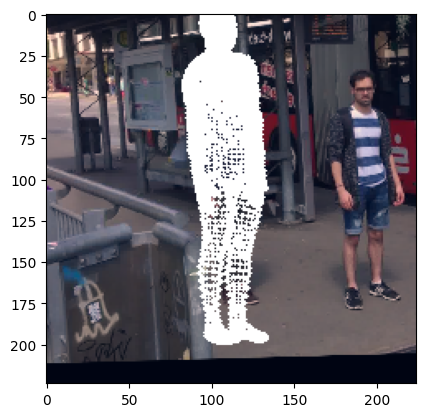

In [771]:
height, width = 224, 224
background = np.zeros((height, width, 3), dtype=np.uint8)
color = (255,255,255)
image1 = draw_vetices(img_np_bgr, gt_2d_vertices, color)

# fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# 在每个子图上显示一个图像
plt.imshow(image1)
# axs[0].imshow(image1)
# axs[0].axis('off')  # 关闭坐标轴
# axs[0].set_title('full vertices : 6890')

In [772]:
proj_2d_joint = orthographic_projection(gt_3d_joints.unsqueeze(0), pred_camera.cuda()).squeeze()

In [773]:
# base = proj_2d_joint[12]
# proj_2d_joint = proj_2d_joint - base
# offset =  gt_2d_joints[12] - proj_2d_joint[12]
# gt_3d_leg_bone_length = proj_2d_joint[0] - proj_2d_joint[12]
# gt_2d_leg_bone_length = gt_2d_joints[0] - gt_2d_joints[12]
# scale = gt_2d_leg_bone_length/gt_3d_leg_bone_length
# adjust_p_2d_j = gt_2d_joints* scale + offset +base

In [774]:
proj_2d_joint

tensor([[-0.0756,  0.9468],
        [-0.0733,  0.5305],
        [-0.1016,  0.0233],
        [ 0.1300, -0.0084],
        [ 0.0780,  0.5211],
        [ 0.0416,  0.9493],
        [-0.1633,  0.1344],
        [-0.1870, -0.1231],
        [-0.1851, -0.3814],
        [ 0.0982, -0.4192],
        [ 0.1150, -0.1626],
        [ 0.1445,  0.1068],
        [-0.0567, -0.5067],
        [-0.0675, -0.7209]], device='cuda:0')

In [775]:
gt_2d_joints = gt_2d_joints[:,:2]

In [776]:
gt_3d_j = gt_3d_joints[:,:3]

In [777]:
P = gt_3d_j
P_prime = gt_2d_joints
def cal_camera_para(P, P_prime):
    A = torch.cat((P[:, :2], torch.ones((P.shape[0], 1), device='cuda:0')), dim=1)
    B = P_prime
    print(A)
    # 使用最小二乘法求解
    solution_x = torch.linalg.lstsq(A, B[:, 0]).solution
    solution_y = torch.linalg.lstsq(A, B[:, 1]).solution
    
    # 提取參數
    s_x = solution_x[0].item()
    s_y = solution_y[1].item()
    s = (s_x + s_y) / 2  # 取 x 和 y 分量中的平均值作為縮放參數
    t_x = solution_x[2].item()
    t_y = solution_y[2].item()
    
    print(f"s = {s}, t_x = {t_x}, t_y = {t_y}")
    pred_camera = torch.tensor([[s, t_x, t_y]])
    return pred_camera
gt_2d_camera = cal_camera_para(P, P_prime)
proj_2d_joint = orthographic_projection(gt_3d_joints.unsqueeze(0), pred_camera.cuda()).squeeze()
reg_3d_joints_from_smpl = smpl.get_h36m_joints(gt_vertices)
reg_3d_joints_from_smpl = reg_3d_joints_from_smpl[:, cfg.H36M_J17_TO_J14, :]

tensor([[-0.0756,  0.9468,  1.0000],
        [-0.0733,  0.5305,  1.0000],
        [-0.1016,  0.0233,  1.0000],
        [ 0.1300, -0.0084,  1.0000],
        [ 0.0780,  0.5211,  1.0000],
        [ 0.0416,  0.9493,  1.0000],
        [-0.1633,  0.1344,  1.0000],
        [-0.1870, -0.1231,  1.0000],
        [-0.1851, -0.3814,  1.0000],
        [ 0.0982, -0.4192,  1.0000],
        [ 0.1150, -0.1626,  1.0000],
        [ 0.1445,  0.1068,  1.0000],
        [-0.0567, -0.5067,  1.0000],
        [-0.0675, -0.7209,  1.0000]], device='cuda:0')
s = 0.775227278470993, t_x = 0.008077776059508324, t_y = -0.13699616491794586


In [778]:
import torch

def cal_camera_para(P, P_prime):
    # 构建 A 矩阵
    ones = torch.ones((P.shape[0], P.shape[1], 1), device=P.device)
    A = torch.cat((P[:, :, :2], ones), dim=2)  # (batch_size, num_points, 3)
    
    # 使用最小二乘法求解
    B_x = P_prime[:, :, 0]  # (batch_size, num_points)
    B_y = P_prime[:, :, 1]  # (batch_size, num_points)
    
    solution_x = torch.linalg.lstsq(A, B_x).solution
    solution_y = torch.linalg.lstsq(A, B_y).solution
    
    # 提取参数
    s_x = solution_x[:, 0]
    s_y = solution_y[:, 1]
    s = (s_x + s_y) / 2  # 取 x 和 y 分量中的平均值作为缩放参数
    t_x = solution_x[:, 2]
    t_y = solution_y[:, 2]
    
    # 构建预测的相机参数
    pred_camera = torch.stack([s, t_x, t_y], dim=1)  # (batch_size, 3)
    return pred_camera

# 示例数据
P = torch.randn(10, 14, 3, device='cuda:0')  # 假设 batch_size=10, num_points=14
P_prime = torch.randn(10, 14, 2, device='cuda:0')

# 计算相机参数
pred_camera = cal_camera_para(P, P_prime)
print(pred_camera.shape)


torch.Size([10, 3])


In [779]:
P_prime_batch = torch.stack([gt_2d_joints,gt_2d_joints],dim=0)
P_batch = torch.stack([gt_3d_j,gt_3d_j],dim=0)

gt_2d_camera = cal_camera_para(P_batch, P_prime_batch)
proj_2d_joint = orthographic_projection(gt_3d_joints.unsqueeze(0), pred_camera.cuda()).squeeze()
reg_3d_joints_from_smpl = smpl.get_h36m_joints(gt_vertices)
reg_3d_joints_from_smpl = reg_3d_joints_from_smpl[:, cfg.H36M_J17_TO_J14, :]

In [780]:
gt_2d_camera.shape

torch.Size([2, 3])

In [781]:
P_prime_batch = torch.stack([gt_2d_joints,gt_2d_joints],dim=0)
P_batch = torch.stack([gt_3d_j,gt_3d_j],dim=0)

In [782]:
P_test.shape

torch.Size([2, 14, 3])

In [783]:
P_prime.unsqueeze(0).shape

torch.Size([1, 10, 14, 2])

In [784]:
P.shape

torch.Size([10, 14, 3])

In [785]:
reg_3d_joints_from_smpl = reg_3d_joints_from_smpl.squeeze()
# gt_2d_joints = gt_2d_joints.squeeze().cuda()

In [786]:
print(reg_3d_joints_from_smpl.shape)
print(gt_2d_joints.shape)

torch.Size([14, 3])
torch.Size([14, 2])


In [787]:
camera_smpl_gt_2d = cal_camera_para(reg_3d_joints_from_smpl.unsqueeze(0), gt_2d_joints.unsqueeze(0))

In [788]:
gt_2d_smpl_joint = orthographic_projection(reg_3d_joints_from_smpl.unsqueeze(0), camera_smpl_gt_2d.cuda()).squeeze()

In [789]:
reg_3d_joints_from_smpl.unsqueeze(0).shape

torch.Size([1, 14, 3])

In [790]:
offset = (gt_2d_joints[12] - gt_2d_smpl_joint[12])
refine_smpl_j = gt_2d_smpl_joint + offset
refine_smpl_v = gt_2d_vertices + offset

In [791]:
offset

tensor([-0.0148,  0.0240], device='cuda:0')

In [792]:
new_cam = camera_smpl_gt_2d.cuda(device)
new_cam[:,1:] += (offset.cuda(device))

In [793]:
camera_smpl_gt_2d

tensor([[0.7598, 0.0091, 0.0921]], device='cuda:0')

In [794]:
new_cam

tensor([[0.7598, 0.0091, 0.0921]], device='cuda:0')

In [795]:
new_proj_2d_joint = orthographic_projection(reg_3d_joints_from_smpl.unsqueeze(0), new_cam.cuda()).squeeze()

Text(0.5, 1.0, 'smpl project reg 2d joint')

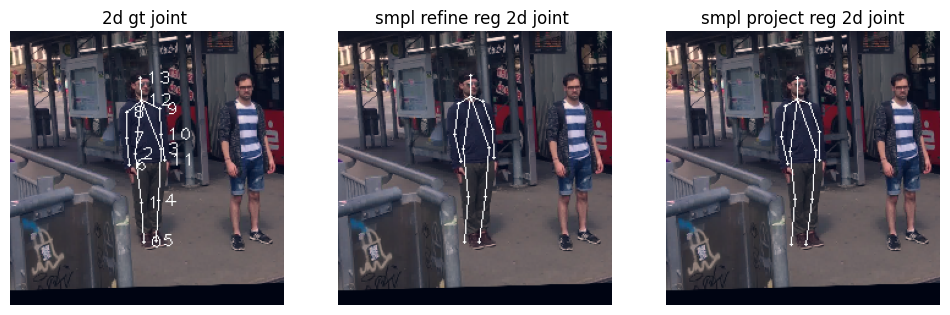

In [796]:
height, width = 224, 224
background = np.zeros((height, width, 3), dtype=np.uint8)
color = (255,255,255)
edges = [(0,1),(1,2),(2,12),(3,4),(4,5),(3,12),(9,10),(9,12),(10,11),(12,13), (12,8), (8,7), (7,6) ]
image1 = draw_vetices(img_np_bgr, gt_2d_joints, color, bone=edges, text=True)
image2 = draw_vetices(img_np_bgr, gt_2d_smpl_joint, color, bone=edges)
# image3 = draw_vetices(img_np_bgr, gt_2d_vertices, color, bone=edges)
# image3 = draw_vetices(img_np_bgr, gt_2d_smpl_joint, color, bone=edges)
# image3 = draw_vetices(img_np_bgr, refine_smpl_j, color, bone=edges)
# image3 = draw_vetices(img_np_bgr, refine_smpl_v, color, bone=edges)
image3 = draw_vetices(img_np_bgr, new_proj_2d_joint, color, bone=edges)
# image3 = draw_vetices(image3, gt_2d_smpl_joint, color, bone=edges)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# 在每个子图上显示一个图像
axs[0].imshow(image1)
axs[0].axis('off')  # 关闭坐标轴
axs[0].set_title('2d gt joint ')

# 在每个子图上显示一个图像
axs[1].imshow(image2)
axs[1].axis('off')  # 关闭坐标轴
axs[1].set_title('smpl refine reg 2d joint ')

# 在每个子图上显示一个图像
axs[2].imshow(image3)
axs[2].axis('off')  # 关闭坐标轴
axs[2].set_title('smpl project reg 2d joint')

In [750]:


import time
start = time.time()
sample = 500000
for i in range(sample):    
    gt_2d_vertices = orthographic_projection(gt_vertices, camera_smpl_gt_2d.cuda()).squeeze()
end = time.time()
print('project time : {}'.format((end-start)))

project time : 24.120231866836548


In [ ]:
import numpy as np
import pandas as pd

# 参数设置
num_samples = 500000
num_points = 483

# 随机生成样本数据
data = np.random.rand(num_samples, num_points * 3)  # 生成范围在 [0, 1) 的随机数

# 创建列标签
columns = []
for i in range(num_points):
    columns.append(f"x{i+1}")
    columns.append(f"y{i+1}")
    columns.append(f"z{i+1}")

# 创建 DataFrame 并保存为 TSV 文件
df = pd.DataFrame(data, columns=columns)
df.to_csv('samples_more.tsv', sep='\t', index=False)

print("样本数据生成并保存为 samples.tsv 文件。")


In [295]:
import pandas as pd

# 读取 TSV 文件
file_path = 'samples_more.tsv'

def read_samples(file_path):
    chunk_size = 10000  # 分块读取，每次读取 10000 行数据
    for chunk in pd.read_csv(file_path, sep='\t', chunksize=chunk_size):
        # samples = chunk.values.reshape((-1, num_points, 2))  # 每个样本有 num_points 个点，每个点有 x, y 坐标
        for sample in samples:
            yield sample

# 使用生成器逐个读取样本
start = time.time()
for i, sample in enumerate(read_samples(file_path)):
    pass
    # print(f"样本 {i+1}:")
    # print(sample)
    # if i >= 1:  # 这里只打印前两个样本，避免输出过多数据
    #     break
end = time.time()
print('read time : {}'.format((end-start)))

read time : 99.59958219528198


In [358]:
h36m_dataset = "/home/juno/datasets/human3.6m/smpl/train.label.smpl.p1.tsv"
coco_dataset = "/home/juno/datasets/coco_smpl/smpl/train.label.tsv"
muco_dataset = "/home/juno/datasets/muco/train.label.tsv"
up3d_dataset = "/home/juno/datasets/up3d/trainval.label.tsv"
mpii_dataset = "/home/juno/datasets/mpii/train.label.tsv"
ddpw_dataset = "/home/juno/datasets/3dpw/train.label.tsv"

In [387]:
def cal_camera_para(P, P_prime):
    # 对数据进行归一化处理
    P_mean = P.mean(dim=0, keepdim=True)
    P_prime_mean = P_prime.mean(dim=0, keepdim=True)
    P_std = P.std(dim=0, keepdim=True)
    P_prime_std = P_prime.std(dim=0, keepdim=True)
    
    P_normalized = (P - P_mean) / P_std
    P_prime_normalized = (P_prime - P_prime_mean) / P_prime_std

    A = torch.cat((P[:, :2], torch.ones((P.shape[0], 1), device='cuda:0')), dim=1)
    B = P_prime
    
    # 使用最小二乘法求解
    solution_x = torch.linalg.lstsq(A, B[:, 0]).solution
    solution_y = torch.linalg.lstsq(A, B[:, 1]).solution
    
    # 提取參數
    s_x = solution_x[0].item()
    s_y = solution_y[1].item()
    s = (s_x + s_y) / 2  # 取 x 和 y 分量中的平均值作為縮放參數
    t_x = solution_x[2].item()
    t_y = solution_y[2].item()
    
    print(f"s = {s}, t_x = {t_x}, t_y = {t_y}")
    pred_camera = torch.tensor([[s, t_x, t_y]])
    return pred_camera

tensor([[506.2160, 622.7914],
        [479.8339, 530.7903],
        [500.9926, 447.9922],
        [445.8150, 441.7249],
        [456.1609, 537.1746],
        [467.2040, 634.1008],
        [515.4759, 456.4058],
        [520.3363, 413.1750],
        [508.1397, 355.9274],
        [453.8017, 359.1605],
        [429.8727, 415.5135],
        [412.8094, 452.7784],
        [480.9083, 339.6174],
        [485.6198, 296.0767]], device='cuda:0')
tensor([[-3.0909e-03,  6.3337e-01,  2.9430e-01],
        [-5.5569e-02,  1.9443e-01,  1.6496e-01],
        [-1.2176e-01, -2.7602e-01,  1.3372e-01],
        [ 1.4131e-01, -2.3508e-01, -5.3213e-02],
        [ 1.0992e-01,  2.2682e-01,  6.0431e-02],
        [ 1.3575e-01,  6.4892e-01,  2.1665e-01],
        [-1.6012e-01, -1.6488e-01,  1.6939e-01],
        [-1.4288e-01, -4.2971e-01,  1.8754e-01],
        [-6.3396e-02, -7.1017e-01,  1.3239e-01],
        [ 1.7083e-01, -6.8654e-01, -5.5005e-02],
        [ 2.1294e-01, -3.9642e-01, -8.3575e-02],
        [ 1.8144e-01, -

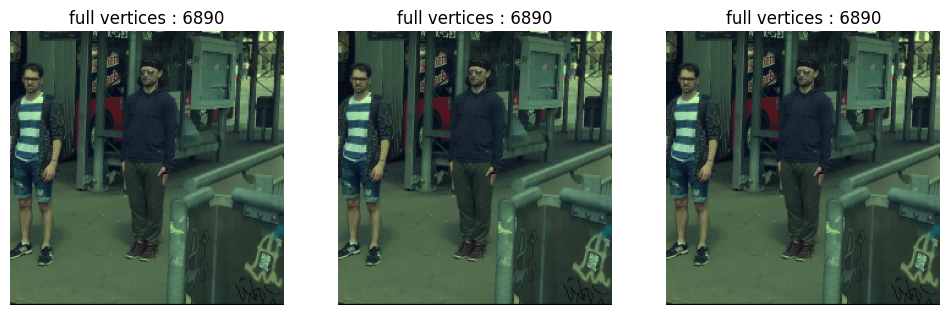

In [513]:
import csv
from src.modeling._smpl import SMPL, Mesh
import torch
import csv
import json
import src.modeling.data.config as cfg

smpl = SMPL().to(torch.device('cuda'))
mesh_sampler = Mesh()
device = torch.device('cuda')
# 定义文件路径
file_path = h36m_dataset

# 初始化要提取的字段名称
fields_to_extract = ['has_2d_joints', '2d_joints', 'betas', 'pose','has_smpl']
criterion_2d_keypoints = torch.nn.MSELoss(reduction='none').cuda(device)

total_sample = 0
no_has_2d_joints = 0
no_2d_joints = 0
no_has_smpl = 0
no_smpl = 0
no_beta = 0
no_pose = 0
# 读取并提取数据
with open(file_path, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')
    # 获取标题
    # headers = next(reader)
    for row in reader:
        # 假设标签在第二列
        total_sample += 1
        name = row[0]
        json_str = row[1]
        # 将 JSON 字符串解析为 Python 对象
        data = json.loads(json_str)[0]  # 获取列表中的第一个字典
        # 提取指定字段的值
        extracted_data = {field: data[field] for field in fields_to_extract}
        
        has_2d_joints = extracted_data[fields_to_extract[0]]
        joints_2d = torch.tensor(extracted_data[fields_to_extract[1]])
        has_smpl = extracted_data[fields_to_extract[4]]
        betas = torch.tensor(extracted_data[fields_to_extract[2]])
        pose = torch.tensor(extracted_data[fields_to_extract[3]])

        # 沒有 2d joints 或 smpl
        if has_2d_joints != 1 or has_smpl != 1:
            continue
        else:
            # 從 smpl 回歸 14 個 3d 關節點
            vertices = smpl(gt_pose.unsqueeze(0), gt_betas.unsqueeze(0))
            reg_3d_joints_from_smpl = smpl.get_h36m_joints(vertices)
            reg_3d_joints_from_smpl = reg_3d_joints_from_smpl[:, cfg.H36M_J17_TO_J14, :].squeeze()
            # 取 GT 的 14 個 2D 關節點
            gt_2d_joints = joints_2d[:,cfg.J24_TO_J14, :].squeeze().cuda()
            gt_2d_joints = gt_2d_joints[:,:2].cuda()
            print(gt_2d_joints)
            print(reg_3d_joints_from_smpl)
            # 用回歸的 3d joint 和 GT 的 2d joint 計算相機參數
            gt_2d_camera = cal_camera_para(reg_3d_joints_from_smpl, gt_2d_joints)
            # 利用剛剛計算的相機參數對回歸的 3d joint 進行投影
            gt_2d_smpl_joint = orthographic_projection(reg_3d_joints_from_smpl.unsqueeze(0), camera_smpl_gt_2d.cuda()).squeeze()
            # 對偏移量進行修正
            offset = (gt_2d_joints[12] - gt_2d_smpl_joint[12])
            new_cam = gt_2d_camera.cuda(device)
            new_cam[:,1:] += (offset.cuda(device))
            print(new_cam)
            refine_2d_smpl_joint = orthographic_projection(reg_3d_joints_from_smpl.unsqueeze(0), new_cam.cuda()).squeeze()
            refine_v = orthographic_projection(vertices, new_cam.cuda()).squeeze()
            
            height, width = 224, 224
            background = np.zeros((height, width, 3), dtype=np.uint8)
            color = (255,255,255)
            edges = [(0,1),(1,2),(2,12),(3,4),(4,5),(3,12),(9,10),(9,12),(10,11),(12,13), (12,8), (8,7), (7,6) ]
            image1 = draw_vetices(img_np_bgr, gt_2d_joints, color, bone=edges, text=True)
            image2 = draw_vetices(img_np_bgr, refine_2d_smpl_joint, color, bone=edges)
            image3 = draw_vetices(img_np_bgr, refine_v, color, bone=edges)
            # image3 = draw_vetices(image3, gt_2d_smpl_joint, color, bone=edges)
            
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            
            # 在每个子图上显示一个图像
            axs[0].imshow(image1)
            axs[0].axis('off')  # 关闭坐标轴
            axs[0].set_title('full vertices : 6890')
            
            # 在每个子图上显示一个图像
            axs[1].imshow(image2)
            axs[1].axis('off')  # 关闭坐标轴
            axs[1].set_title('full vertices : 6890')
            
            # 在每个子图上显示一个图像
            axs[2].imshow(image3)
            axs[2].axis('off')  # 关闭坐标轴
            axs[2].set_title('full vertices : 6890')

        # print(extracted_data[fields_to_extract[2]])
        if total_sample >= 1:
            break
# print("total number of sample : ", total_sample)
# print("total number of no has 2d joints : ", no_has_2d_joints)
# print("total number of no 2d joints : ", no_2d_joints)
# print("total number of no has smpl : ", no_has_smpl)
# print("total number of no smpl : ", no_smpl)
# print("total number of no beta : ", no_beta)
# print("total number of no pose : ", no_pose)

        

In [369]:
import torch

# 创建一个示例 tensor
tensor = torch.tensor([0, 0, 0, 0, 1])

# 检查 tensor 中是否包含 0
contains_zero = torch.all(torch.eq(tensor, 0))
print(contains_zero)  # 输出: True

tensor(False)


In [ ]:
# 確認修正後的投影參數正確
refine_2d_smpl_joint = orthographic_projection(reg_3d_joints_from_smpl.unsqueeze(0), new_cam.cuda()).squeeze()
refine_v = orthographic_projection(vertices.unsqueeze(0), new_cam.cuda()).squeeze()

height, width = 224, 224
background = np.zeros((height, width, 3), dtype=np.uint8)
color = (255,255,255)
edges = [(0,1),(1,2),(2,12),(3,4),(4,5),(3,12),(9,10),(9,12),(10,11),(12,13), (12,8), (8,7), (7,6) ]
image1 = draw_vetices(img_np_bgr, gt_2d_joints, color, bone=edges, text=True)
image2 = draw_vetices(img_np_bgr, refine_2d_smpl_joint, color, bone=edges)
image3 = draw_vetices(img_np_bgr, refine_v, color, bone=edges)
# image3 = draw_vetices(image3, gt_2d_smpl_joint, color, bone=edges)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# 在每个子图上显示一个图像
axs[0].imshow(image1)
axs[0].axis('off')  # 关闭坐标轴
axs[0].set_title('full vertices : 6890')

# 在每个子图上显示一个图像
axs[1].imshow(image2)
axs[1].axis('off')  # 关闭坐标轴
axs[1].set_title('full vertices : 6890')

# 在每个子图上显示一个图像
axs[2].imshow(image3)
axs[2].axis('off')  # 关闭坐标轴
axs[2].set_title('full vertices : 6890')

In [ ]:
def ruber_loss(vertex_pred, vertex_targets, vertex_weights, percent, normalize=True, reduction=True):
    """
    :param percent:
    :param vertex_pred:     [b,vn*2,h,w]
    :param vertex_targets:  [b,vn*2,h,w]
    :param vertex_weights:  [b,1,h,w]
    :param normalize:
    :param reduction:
    :return:
    """
    # error_weights = (err_pred[:, None, :, :] < 0.5).detach()
    b, ver_dim, _, _ = vertex_pred.shape
    abs_diff = abs(vertex_weights * (vertex_pred - vertex_targets))
    c = abs_diff.view(b, ver_dim, -1).max(-1)[0][:, :, None, None] * percent / 100.
    ruber_sign = (abs_diff <= c).detach().float()
    in_loss = abs_diff * ruber_sign + (torch.sqrt((2. * c * abs_diff - c ** 2) * (1. - ruber_sign) + 1e-12) - 1e-6)

    if normalize:
        in_loss = torch.sum(in_loss.view(b, -1), 1) / (2. * torch.sum(vertex_weights.view(b, -1), 1) + 1e-6)

    if reduction:
        in_loss = torch.mean(in_loss)

    return in_loss

In [ ]:
# =========================== test for batch ==========================================

In [824]:
(img_keys, images, annotations) = train_dataloader[10]
(img_keys1, images1, annotations1) = train_dataloader[11]

In [825]:
gt_2d_joints0 = annotations['joints_2d'].cuda(device)
gt_2d_joints0 = gt_2d_joints0[cfg.J24_TO_J14, :]
gt_2d_joints1 = annotations1['joints_2d'].cuda(device)
gt_2d_joints1 = gt_2d_joints1[cfg.J24_TO_J14, :]

In [826]:
gt_pose0 = annotations['pose'].cuda()
gt_betas0 = annotations['betas'].cuda()
gt_vertices0 = smpl(gt_pose0.unsqueeze(0), gt_betas0.unsqueeze(0))
gt_pose1 = annotations1['pose'].cuda()
gt_betas1 = annotations1['betas'].cuda()
gt_vertices1 = smpl(gt_pose1.unsqueeze(0), gt_betas1.unsqueeze(0))

In [827]:
gt_2d_joints = torch.stack((gt_2d_joints0, gt_2d_joints1), dim=0)
gt_vertices = torch.cat((gt_vertices0, gt_vertices1), dim=0)

In [828]:
gt_smpl_3d_joint = smpl.get_h36m_joints(gt_vertices)
gt_smpl_3d_joint = gt_smpl_3d_joint[:, cfg.H36M_J17_TO_J14, :]

In [829]:
def cal_batch_camera_para(smpl_3d_joints, gt_2d_joints):
    batch_size, num_points, _ = smpl_3d_joints.shape
    
    # 构建 A 矩阵
    ones = torch.ones((batch_size, num_points, 1), device=smpl_3d_joints.device)
    A = torch.cat((smpl_3d_joints[:, :, :2], ones), dim=2)  # (batch_size, num_points, 3)
    
    # 使用最小二乘法求解
    B_x = gt_2d_joints[:, :, 0]  # (batch_size, num_points)
    B_y = gt_2d_joints[:, :, 1]  # (batch_size, num_points)
    
    solution_x = torch.linalg.lstsq(A, B_x).solution
    solution_y = torch.linalg.lstsq(A, B_y).solution
    
    # 提取参数
    s_x = solution_x[:, 0]
    s_y = solution_y[:, 1]
    s = (s_x + s_y) / 2  # 取 x 和 y 分量中的平均值作为缩放参数
    t_x = solution_x[:, 2]
    t_y = solution_y[:, 2]
    
    # 构建预测的相机参数
    coarse_camera = torch.stack([s, t_x, t_y], dim=1)  # (batch_size, 3)
    gt_2d_smpl_joint = orthographic_projection(smpl_3d_joints, coarse_camera).squeeze()
    
    # 计算 offset
    offset = gt_2d_joints[:, 12, :2] - gt_2d_smpl_joint[:, 12, :]
    
    # 调整 fine_cam
    fine_cam = coarse_camera.clone()
    fine_cam[:, 1:] += offset
    return fine_cam

In [830]:
pseudo_cam = cal_batch_camera_para(gt_smpl_3d_joint, gt_2d_joints)

In [831]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 將 PyTorch 張量轉換為 NumPy 陣列
img_np = images.numpy()
min_val = img_np.min()
max_val = img_np.max()
img_np = (img_np - min_val) / (max_val - min_val)

# 轉換顏色通道從 (3, 224, 224) 到 (224, 224, 3)
img_np = np.transpose(img_np, (1, 2, 0))
img_np_bgr = img_np[:, :, ::]

img_np = images1.numpy()
min_val = img_np.min()
max_val = img_np.max()
img_np = (img_np - min_val) / (max_val - min_val)

# 轉換顏色通道從 (3, 224, 224) 到 (224, 224, 3)
img_np = np.transpose(img_np, (1, 2, 0))
img_np_bgr1= img_np[:, :, ::]

In [832]:
refine_2d_smpl_joint = orthographic_projection(gt_smpl_3d_joint, pseudo_cam.cuda()).squeeze()
refine_v = orthographic_projection(gt_vertices, pseudo_cam.cuda()).squeeze()

Text(0.5, 1.0, 'project smpl vertices')

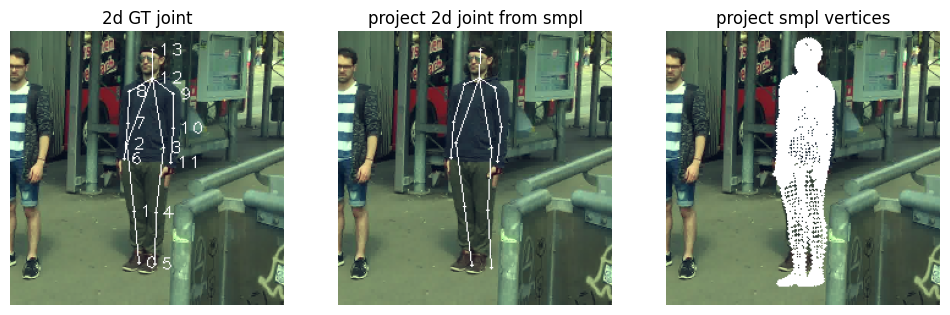

In [834]:
height, width = 224, 224
color = (255,255,255)

edges = [(0,1),(1,2),(2,12),(3,4),(4,5),(3,12),(9,10),(9,12),(10,11),(12,13), (12,8), (8,7), (7,6) ]
image1 = draw_vetices(img_np_bgr, gt_2d_joints[0], color, bone=edges, text=True)
image2 = draw_vetices(img_np_bgr, refine_2d_smpl_joint[0], color, bone=edges)
image3 = draw_vetices(img_np_bgr, refine_v[0], color, bone=edges)
# image3 = draw_vetices(image3, gt_2d_smpl_joint, color, bone=edges)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# 在每个子图上显示一个图像
axs[0].imshow(image1)
axs[0].axis('off')  # 关闭坐标轴
axs[0].set_title('2d GT joint')

# 在每个子图上显示一个图像
axs[1].imshow(image2)
axs[1].axis('off')  # 关闭坐标轴
axs[1].set_title('project 2d joint from smpl')

# 在每个子图上显示一个图像
axs[2].imshow(image3)
axs[2].axis('off')  # 关闭坐标轴
axs[2].set_title('project smpl vertices')

Text(0.5, 1.0, 'full vertices : 6890')

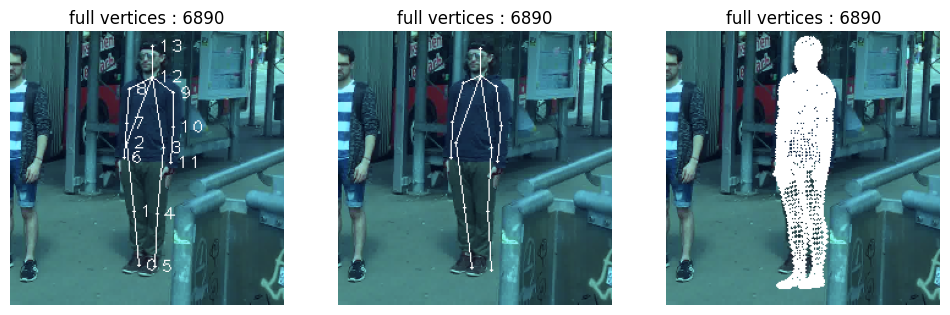

In [835]:
height, width = 224, 224
color = (255,255,255)

edges = [(0,1),(1,2),(2,12),(3,4),(4,5),(3,12),(9,10),(9,12),(10,11),(12,13), (12,8), (8,7), (7,6) ]
image1 = draw_vetices(img_np_bgr1, gt_2d_joints[1], color, bone=edges, text=True)
image2 = draw_vetices(img_np_bgr1, refine_2d_smpl_joint[1], color, bone=edges)
image3 = draw_vetices(img_np_bgr1, refine_v[1], color, bone=edges)
# image3 = draw_vetices(image3, gt_2d_smpl_joint, color, bone=edges)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# 在每个子图上显示一个图像
axs[0].imshow(image1)
axs[0].axis('off')  # 关闭坐标轴
axs[0].set_title('full vertices : 6890')

# 在每个子图上显示一个图像
axs[1].imshow(image2)
axs[1].axis('off')  # 关闭坐标轴
axs[1].set_title('full vertices : 6890')

# 在每个子图上显示一个图像
axs[2].imshow(image3)
axs[2].axis('off')  # 关闭坐标轴
axs[2].set_title('full vertices : 6890')